
<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>
 
 
# Laboratorio: Análisis y Modelado de Series Temporales con SARIMAX

En este laboratorio, practicarás el análisis y modelado de series temporales utilizando el modelo SARIMAX. 
Objetivos del laboratorio

- Analizar series temporales:
	
    - Identificar tendencias, estacionalidad y posibles rupturas estructurales en los datos.
	
    - Verificar la estacionaridad de la serie mediante pruebas estadísticas y visuales.
	
    - Realizar análisis de autocorrelación (ACF) y autocorrelación parcial (PACF).

- Modelar la serie temporal:
	
    - Ajustar un modelo SARIMAX adecuado para los datos proporcionados.
	
    - Evaluar los resultados del modelo e interpretar los parámetros obtenidos.

- Interpretar gráficas y resultados:
	
    - Explicar de forma detallada el significado de las gráficas y resultados generados durante cada etapa del análisis.

# Instrucciones

- Parte 1: Carga y exploración inicial de los datos

    - Descarga el conjunto de datos proporcionado, que contiene una serie temporal de valores relacionados con ventas mensuales de una empresa ficticia durante los últimos 5 años.

    - Realiza una exploración inicial:

        - Gráfica la serie temporal completa para identificar posibles tendencias y estacionalidades.

        - Comenta tus observaciones iniciales sobre los patrones que encuentres.

- Parte 2: Estacionaridad


    - Evalúa si la serie es estacionaria:

    - Aplica el test de Dickey-Fuller aumentado (ADF).

    - Si es necesario, realiza transformaciones (diferenciación o logaritmos) para convertir la serie en estacionaria.

    - Genera una gráfica comparativa que muestre la serie original y la transformada, indicando las diferencias visuales.

    - Escribe una interpretación de los resultados del test ADF y de la gráfica.

- Parte 3: Análisis de autocorrelaciones


    - Genera los gráficos de ACF (Autocorrelation Function) y PACF (Partial Autocorrelation Function).

    - Identifica:

        - El orden de diferenciación necesario (si aún no lo has hecho).

        - Los posibles valores para los parámetros p y q del modelo SARIMAX.

    - Explica qué indican las autocorrelaciones encontradas y cómo las utilizarás para definir los parámetros del modelo.

- Parte 4: Ajuste del modelo SARIMAX


    - Ajusta un modelo SARIMAX utilizando los parámetros identificados.

    - Evalúa el ajuste:

        - Observa los residuos del modelo.

        - Verifica si cumplen las condiciones de ruido blanco mediante análisis visual y pruebas estadísticas.

    - Ajusta el modelo si es necesario, iterando sobre los parámetros.

- Parte 5: Interpretación y predicción


    - Interpreta los coeficientes estimados del modelo (incluyendo estacionalidad y efectos externos si aplican).

    - Genera una predicción para los próximos 12 meses.

    - Gráfica las predicciones junto con la serie temporal original.

    - Comenta sobre:

        - La calidad de las predicciones.

        - La utilidad del modelo para la toma de decisiones.



In [4]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Visualizaciones
# -----------------------------------------------------------------------
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


# Analisis Exploratorio Series Temporales
# -----------------------------------------------------------------------
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from itertools import product


# Otros
# -----------------------------------------------------------------------
from tqdm import tqdm


from src import soporte_sarima as ss

## Parte 1: carga y exploración de los datos

In [50]:
df = pd.read_csv("datos/Truck_sales.csv")
df.head()

,Month-Year,Number_Trucks_Sold
0,03-Jan,155
1,03-Feb,173
2,03-Mar,204
3,03-Apr,219
4,03-May,223


In [51]:
df[["Year", "Month"]] = df["Month-Year"].str.split("-", expand= True)

In [52]:
df["Year"] = pd.to_datetime(df["Year"], format="%y").dt.year
df["Month"] = pd.to_datetime(df["Month"], format="%b").dt.month
df["Date"] = pd.to_datetime(df[["Year", "Month"]].assign(Day=1))
df.drop(columns = ["Month-Year", "Year", "Month"], inplace=True)

In [53]:
st = ss.TimeSeriesAnalysis(df, "Date", "Number_Trucks_Sold")

In [54]:
st.exploracion_datos()

El número de filas es 144 y el número de columnas es 1

----------

En este conjunto de datos tenemos 21 valores duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Number_Trucks_Sold,144.0,428.729167,188.633037,152.0,273.5,406.0,560.25,958.0


In [55]:
st.comprobar_serie_continua()

La serie temporal es continua, no faltan meses.


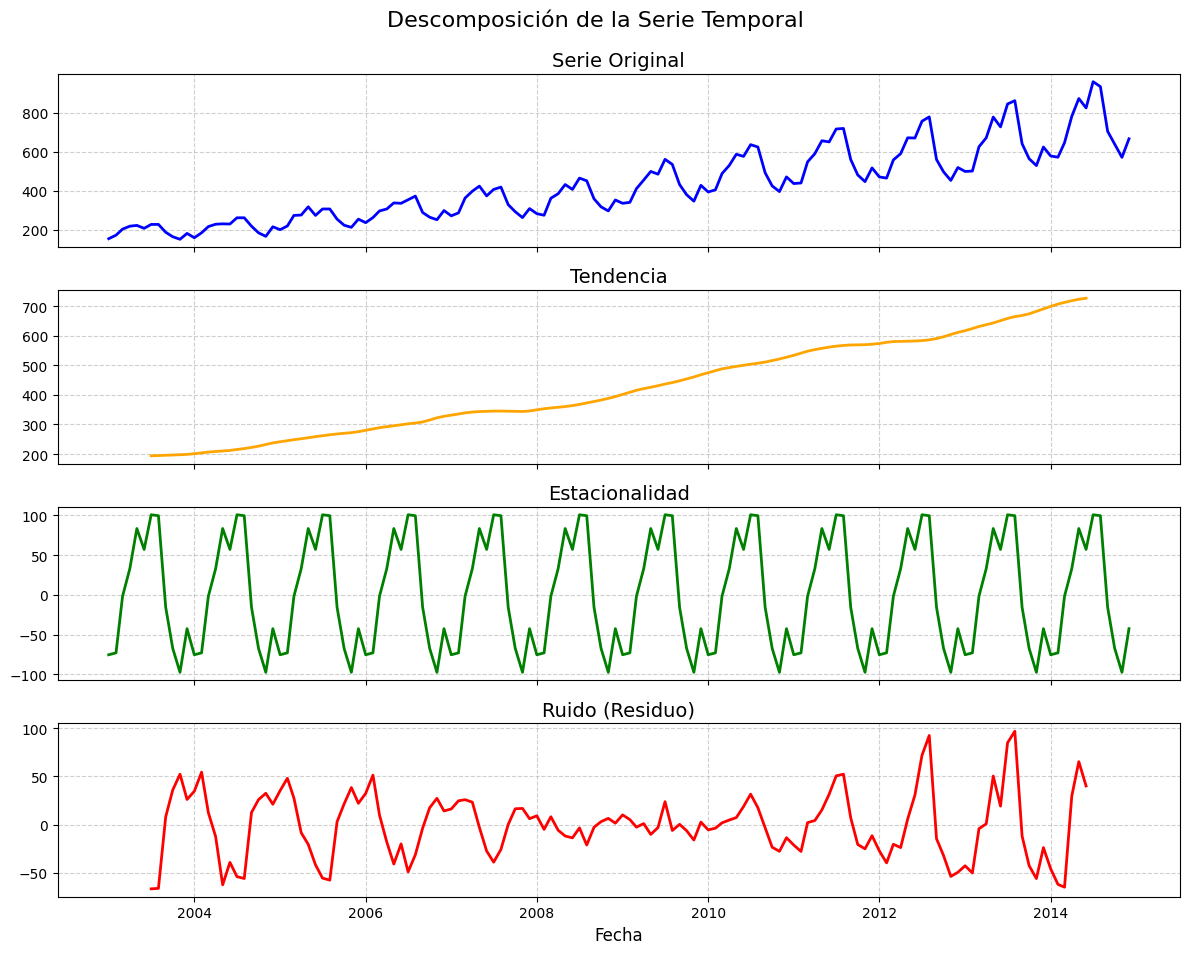

In [56]:
st.detectar_estacionalidad()

- De la exploración inicial, podemos concluir que tenemos 144 datos en una serie continua, que muestra tanto tendencia como estacionalidad.

- La tendencia indica que las ventas aumentan año tras año, mientras la estacionalidad muestra que hay ciclos bien definidos que se repiten cada año.

## Parte 2: Estacionaridad

In [57]:
st.prueba_estacionariedad()

ADF Statistic: 1.1158932574252713
p-value: 0.9953500083802602
Valores Críticos:
1%: -3.482087964046026
5%: -2.8842185101614626
10%: -2.578864381347275
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


- Tras la prueba de Dickey-Fuller, podemos ver que la serie no es estacionaria (sí cambia en el tiempo).

- El método SARIMAX, por ser similar a una regresión lineal, requiere que la serie esté lo más "aplanada", con lo cual, la aplanamos usando el parámetro diferenciación.

- Cuando tenemos una tendencia creciente pero continua, usaremos el valor de 1, y si vemos picos pronunciados, usaremos 2. En este caso, será el 1.

In [58]:
serie_aplanada = np.log(df["Number_Trucks_Sold"])

<Axes: xlabel='None', ylabel='Number_Trucks_Sold'>

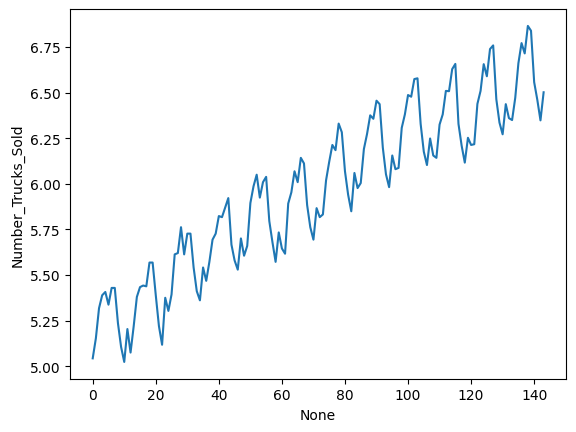

In [59]:
sns.lineplot(x= df.index, y= serie_aplanada)

## Parte 3: Análisis de autocorrelaciones

<Figure size 1200x1000 with 0 Axes>

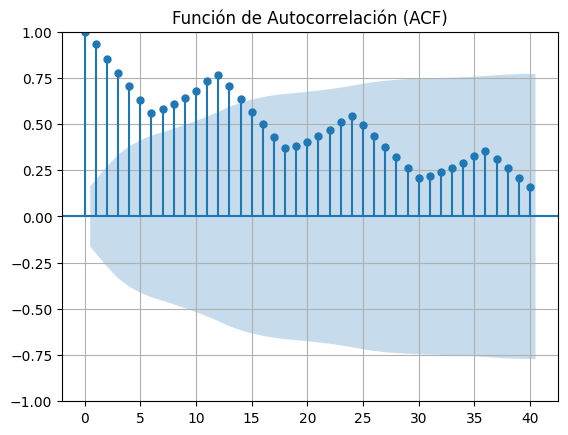

<Figure size 1200x1000 with 0 Axes>

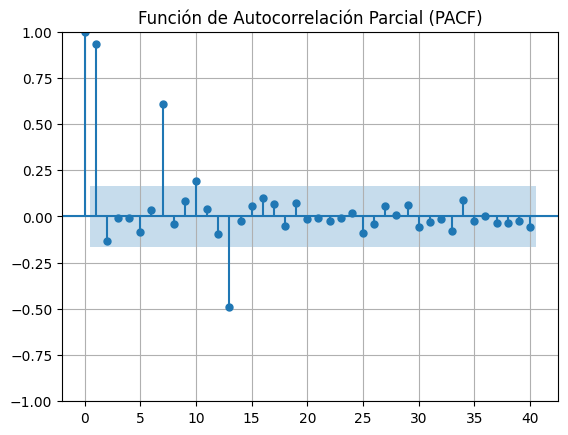

In [60]:
st.graficar_acf_pacf()

- Las gráficas de autocorrelación nos permiten asignar los valores de p y de q, contando los puntos que se encuentran fuera del intervalo de confianza. Los que se encuentran dentro, tienen una baja correlación.

- En el caso de la p, contamos 14 lags fuera del intervalo en la gráfica de ACF, y en en el caso de q, son 2 lags los que se cuenta fuera en la PACF.

## Parte 4: Ajuste del modelo SARIMAX

- Cambiamos la columna date al índice e inicializamos la clase.

In [61]:
df.set_index("Date", inplace=True)

In [86]:
sarima = ss.SARIMAModel()

- Definimos los parámetros de P, Q y seasonal_order_ranges, y generamos los parámetros de prueba para el modelo.

In [87]:
ps = range(1, 4) # usamos 4 por dar un poco de holgura con nuestra P, que es 2
qs = range(1, 11)
sor = (range(1,2),range(1,2),range(1,2),[12])

In [88]:
parametros = sarima.generar_parametros(ps, qs, sor)

In [89]:
parametros[:3]

[(1, 1, (1, 1, 1, 12)), (1, 2, (1, 1, 1, 12)), (1, 3, (1, 1, 1, 12))]

- Separamos los datos en train y test para entrenar al modelo.

In [90]:
datos_en_test = int(df.shape[0]*0.3)
y_train = df.iloc[:-datos_en_test]
y_test = df.iloc[-datos_en_test:]

- Y evaluamos los distintos parámetros para encontrar los mejores.

  0%|          | 0/30 [00:00<?, ?it/s]/Users/davidfranco/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/davidfranco/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
  3%|▎         | 1/30 [00:00<00:07,  3.95it/s]/Users/davidfranco/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/davidfranco/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
  7%|▋      

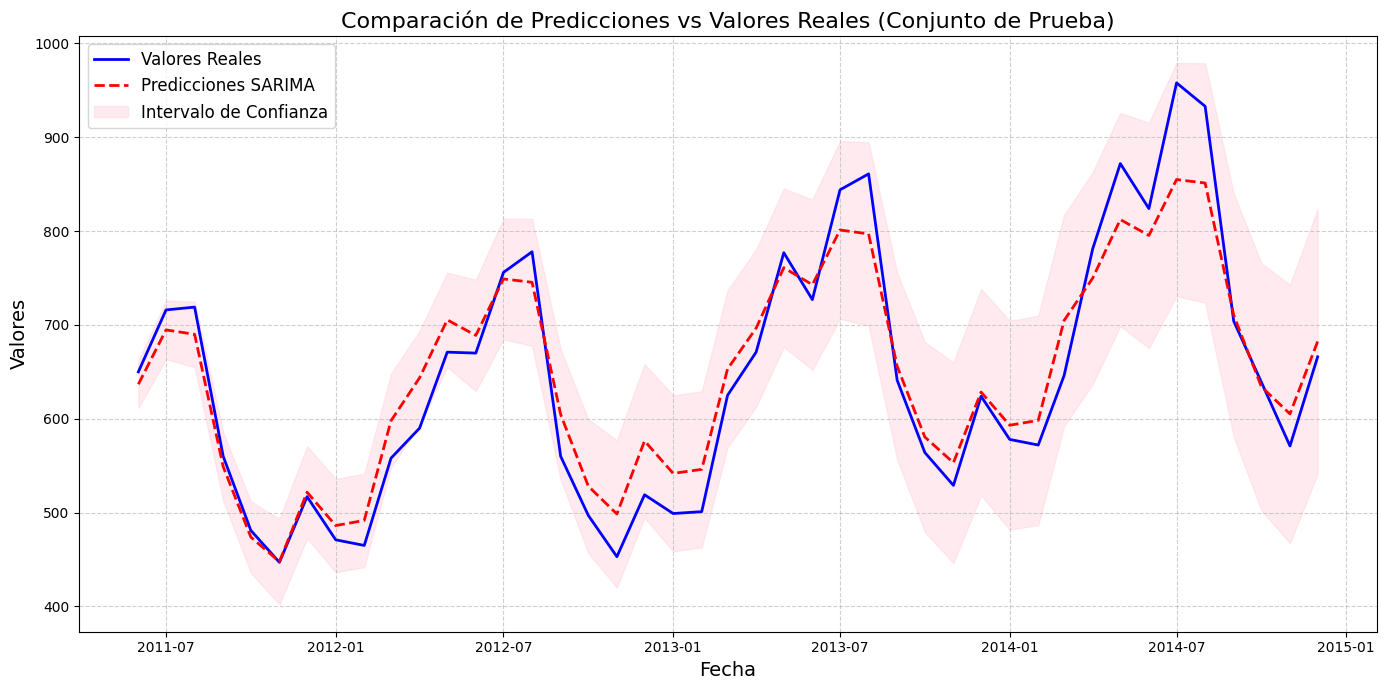

,p,q,seasonal_order,RMSE
8,1,9,"(1, 1, 1, 12)",37.167885
18,2,9,"(1, 1, 1, 12)",37.203827
28,3,9,"(1, 1, 1, 12)",37.710454
9,1,10,"(1, 1, 1, 12)",37.868256
16,2,7,"(1, 1, 1, 12)",38.149771
7,1,8,"(1, 1, 1, 12)",39.265202
15,2,6,"(1, 1, 1, 12)",39.364856
6,1,7,"(1, 1, 1, 12)",39.804976
17,2,8,"(1, 1, 1, 12)",39.869287
22,3,3,"(1, 1, 1, 12)",39.905053


In [92]:
sarima.evaluar_modelos(y_train, y_test, parametros, 1, df.shape[0], "Number_Trucks_Sold")

- Vemos que, el mejor modelo surge de la combinación de parámetros 1-9-(1,1,1,12), con un RSME de 37. Es un error alto considerando la escala de las ventas, pero es nuestro mejor modelo.

## Parte 5: Interpretación y predicción

- Hemos visto las predicciones de manera gráfica, pero también podemos ver los valores predichos en un DF.

In [ ]:
modelo_sarima = SARIMAX(y_train,
                    order=(1, 1, 9), #P, d y q. No puedo decirle que use más de 11 errores, si le decimos que nuestros ciclos (meses) son de 12.
                    seasonal_order=(1, 1, 1, 12)).fit(disp= False) # P, D, Q, m
pred_y_test = modelo_sarima.predict(start= len(y_train), end=len(df)-1)
y_test["Predicted"] = pred_y_test.astype(int)
y_test.head(12)

/Users/davidfranco/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/davidfranco/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/davidfranco/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/davidfranco/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/yj/y1bv8zk12j11bnjq1hc6x_d80000gn/T/

,Number_Trucks_Sold,Predicted
Date,,
2011-06-01,650,644
2011-07-01,716,710
2011-08-01,719,691
2011-09-01,560,557
2011-10-01,481,485
2011-11-01,447,443
2011-12-01,517,516
2012-01-01,471,482
2012-02-01,465,496


- Puede verse que, las predicciones están bastante ajustadas a la realidad para la mayoría de meses, pero hay problemas en febrero y marzo, donde las predicciones se alejan significativamente de la realidad.

- Con la mejor combinación, vamos a pasar todos los datos al modelo, y así, podemos realizar la predicción para los siguientes 12 meses.

In [97]:
order=(1, 1, 9) # p, d, q
seasonal_order=(1, 1, 1, 12)  # P, D, Q, m

prediccion = sarima.predecir(df, order, seasonal_order, 12)
prediccion

/Users/davidfranco/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/davidfranco/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/davidfranco/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,predicted_mean
2015-01-01,639.413829
2015-02-01,620.502126
2015-03-01,723.086038
2015-04-01,849.659791
2015-05-01,944.315289
2015-06-01,886.221625
2015-07-01,1027.804509
2015-08-01,997.026166
2015-09-01,777.796242
2015-10-01,705.295510


- Y la graficamos junto al conjunto real.

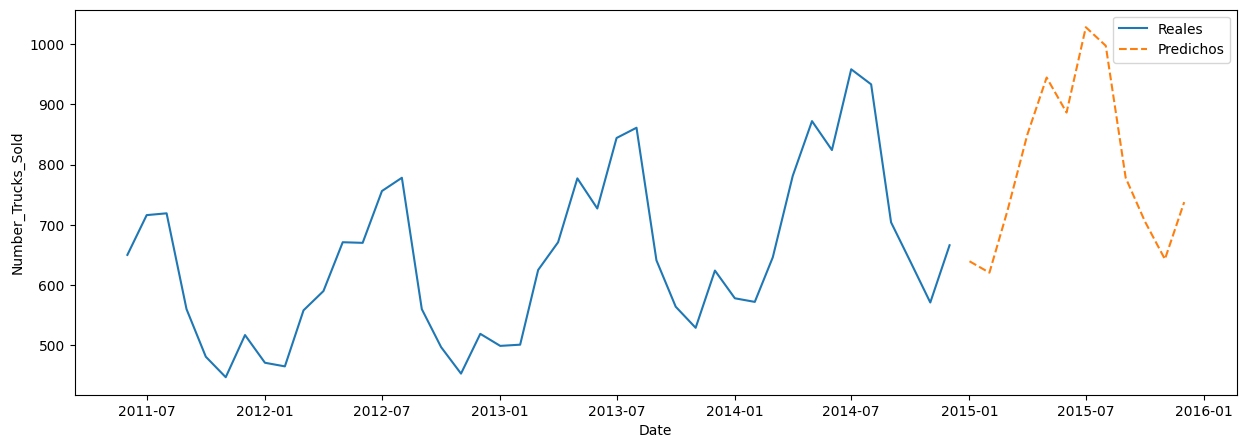

In [101]:
sarima.plot_prediccion(y_test, prediccion, "Number_Trucks_Sold")

- Puede verse que, la predicción se ajusta a la tendencia y la estacionalidad observadas en los datos reales, por lo que, el modelo funciona.

# Serie BBVA

In [24]:
df_bbva = pd.read_csv("datos/datos-stocks/BBVA.csv")
df_bbva.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1988-12-15,3.844128,3.857569,3.817246,3.817246,0.041762,1782700
1,1988-12-16,3.817246,3.817246,3.803805,3.803805,0.041615,777400
2,1988-12-19,3.803805,3.803805,3.790364,3.790364,0.041468,411000
3,1988-12-20,3.790364,3.803805,3.790364,3.790364,0.041468,134800
4,1988-12-21,3.790364,3.803805,3.790364,3.803805,0.041615,242600


In [25]:
df_bbva.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"], inplace=True)

In [26]:
df_bbva["Date"] = pd.to_datetime(df_bbva["Date"], format="%Y-%m-%d")

In [66]:
df_bbva_reducido.reset_index(inplace=True)

In [67]:
st_bbva = ss.TimeSeriesAnalysis(df_bbva_reducido, "Date", "Close")

In [28]:
df_bbva.duplicated().sum()

np.int64(0)

In [29]:
st_bbva.exploracion_datos()

El número de filas es 7885 y el número de columnas es 1

----------

En este conjunto de datos tenemos 5081 valores duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Close,7885.0,9.713759,5.635297,2.029592,4.583384,9.16,13.125143,25.384148


In [30]:
st_bbva.comprobar_serie_continua()

La serie temporal es continua, no faltan meses.


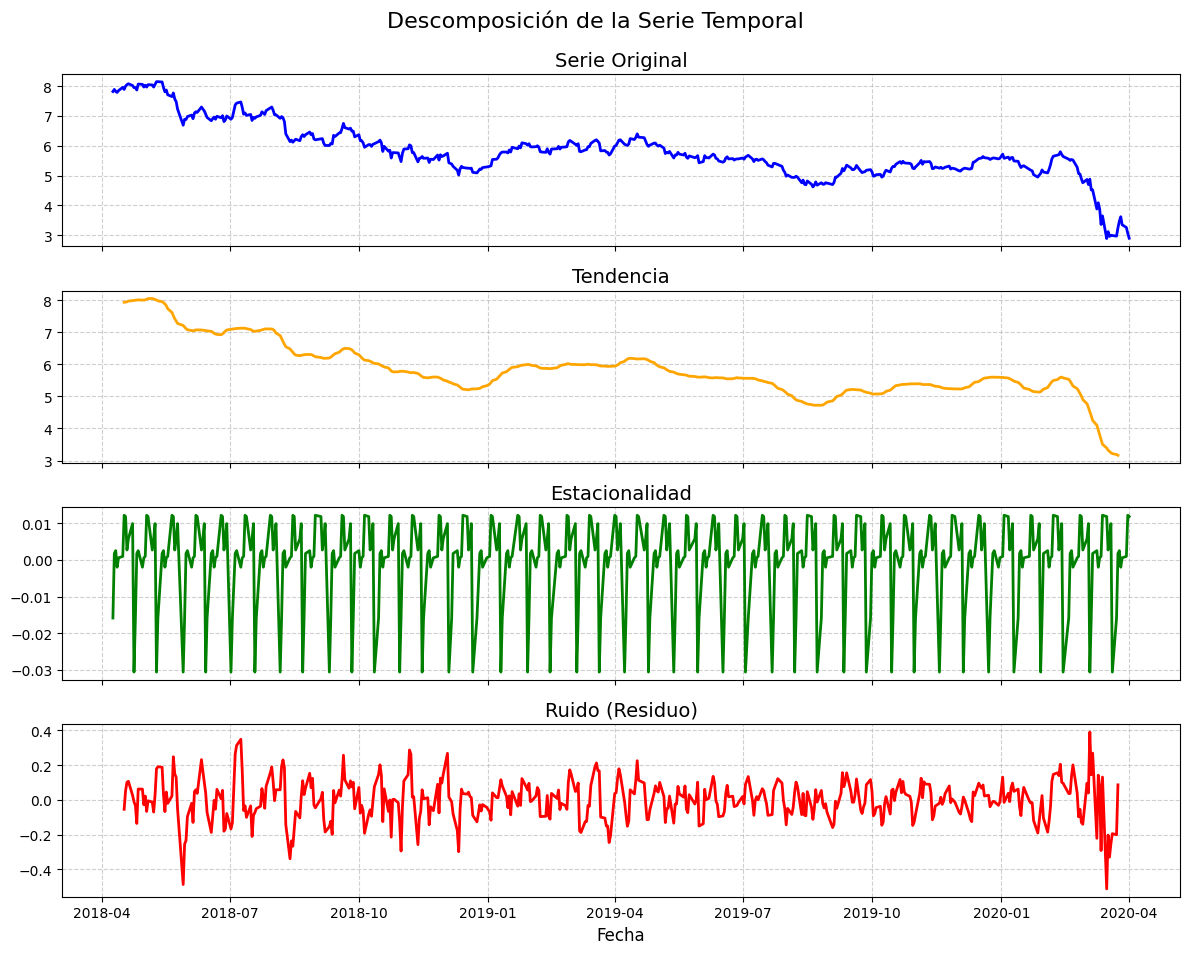

In [68]:
st_bbva.detectar_estacionalidad()

- Tiene sentido que las acciones no sean estacionales, y que las tendencias varíen con el tiempo, por la naturaleza de las empresas y los ciclos económicos.

- En el residuo también puede verse el impacto de la crisis .com en 1997 y la recesión del 2008.

In [32]:
st_bbva.prueba_estacionariedad()

ADF Statistic: -1.758028358763948
p-value: 0.40148939445707876
Valores Críticos:
1%: -3.4311833044118436
5%: -2.861908259874245
10%: -2.5669660201062925
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


In [39]:
df_bbva.set_index("Date", inplace=True)

In [57]:

from statsmodels.tsa.arima.model import ARIMA

def arima_model(data, order, train_ratio=0.7, forecast_steps=12):
    """
    Fits an ARIMA model on time series data and forecasts future values.

    Parameters:
    - data (pd.Series): The time series data.
    - order (tuple): The ARIMA (p, d, q) order.
    - train_ratio (float): Ratio of data used for training. Default is 80%.
    - forecast_steps (int): Number of steps to forecast.

    Returns:
    - dict: A dictionary with keys 'model', 'train', 'test', 'forecast', and 'rmse'.
    """
    # Ensure input is a pandas Series
    if not isinstance(data, pd.Series):
        raise ValueError("Input debe ser una serie.")
    
    # Separar train and test
    train_size = int(len(data) * train_ratio)
    train, test = data[:train_size], data[train_size:]
    
    # Fit
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    
    # Predicción sobre test
    start = len(train)
    end = len(data) - 1
    predictions = model_fit.predict(start=start, end=end)
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    
    # Predicción futura
    future_forecast = model_fit.forecast(steps=forecast_steps)
    
    resultados = {
        "model": model_fit,
        "train": train,
        "test": test,
        "predictions": predictions,
        "rmse": rmse,
        "forecast": future_forecast
    }

    return resultados

In [62]:
df_bbva_reducido = df_bbva.tail(500).copy()

In [58]:
dicc_resultados_arima = arima_model(df_bbva_reducido["Close"], (2, 1, 200))

/Users/davidfranco/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/davidfranco/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/davidfranco/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/davidfranco/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA 

In [61]:
df_bbva_reducido.tail(10)

,Close
Date,
2020-03-19,3.00
2020-03-20,2.99
2020-03-23,2.97
2020-03-24,3.25
2020-03-25,3.47
2020-03-26,3.62
2020-03-27,3.35
2020-03-30,3.26
2020-03-31,3.06


In [60]:
dicc_resultados_arima["forecast"]

350    4.697009
351    4.736075
352    4.711547
353    4.663207
354    4.658003
355    4.622401
356    4.700824
357    4.631998
358    4.639677
359    4.637087
360    4.745334
361    4.669439
Name: predicted_mean, dtype: float64